# Assignment 4: CNN for airfoils
In this assignment you will train a CNN for prediction of Angle of Attack of airfoils from images. You will be using TensorFlow <code>ImageDataGenerator</code> and should aim to predict the correct AoA at least 99% of the time.

To pass this assigment, your code needs to **pass all the tests**. 

## DATA
You will be using a custom-made database of over 6600 NACA 4-digit code airfoils. All airfoils have Reynolds No. of 50000, Mach  No. of 0.3 and an Angle of Attack (AoA) between -3$^o$ and 3$^o$. The <b>publicdata</b> folder contains:
- a csv file named <code>airfoils_Re_03.csv</code> with paths and parameters of each airfoil (each row represents one airfoil)
- all images split into 7 folders, one for each AoA.


You should import the .csv file into <code>pandas dataframe</code> and use TensorFlow <code>ImageDataGenerator</code> to create training and validation datasets.

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random


In [ ]:
!zip -r ai.zip /content/drive/MyDrive/AI4AE/

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/AI4AE/publicdata.zip
!nvidia-smi
# folderPath = '/content/resource/asnlib/publicdata'

Streaming output truncated to the last 5000 lines.
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA1315a_-1Re_50000M_0.5.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA0610a_-1Re_50000M_0.8.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA2521a_-1Re_50000M_0.5.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA2505a_-1Re_50000M_0.3.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA5016a_-1Re_50000M_0.3.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA0723a_-1Re_50000M_0.3.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA3412a_-1Re_50000M_0.5.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA1630a_-1Re_50000M_0.5.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA0214a_-1Re_50000M_0.8.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA1614a_-1Re_50000M_0.3.jpg  
  inflating: resource/asnlib/publicdata/airfoils-1deg/NACA2602a_-1Re_50000M_0.5.jpg  
  i

### Data - part 1
Import data from the csv file, split it into training and testing set and save it in a dataframe named <code>my_df_train</code> and <code>my_df_test</code>.

NB. You may need to reset indexes after the split if you want to access rows by indices.

In [3]:
###
csvPath = '/content/resource/asnlib/publicdata/airfoils_Re_03.csv'
all_data_df = pd.read_csv(csvPath)
all_data_df['AoA'] = all_data_df['AoA'].apply(str)
from sklearn.model_selection import train_test_split
my_df_train, my_df_test = train_test_split(all_data_df, test_size=0.1, random_state=42)
%cd /content/resource/asnlib/publicdata/
###


/content/resource/asnlib/publicdata


In [4]:
my_df_train

fpath   NACA_no  ...       CD      CL
486   airfoils-1deg/NACA2016a_-1Re_50000M_0.3.jpg  NACA2016  ...  0.03714  0.0607
1468  airfoils-2deg/NACA2015a_-2Re_50000M_0.3.jpg  NACA2015  ...  0.02983 -0.3516
6477    airfoils3deg/NACA4215a_3Re_50000M_0.3.jpg  NACA4215  ...  0.03571  0.7137
2166  airfoils-3deg/NACA0912a_-3Re_50000M_0.3.jpg  NACA0912  ...  0.02362 -0.4804
4034    airfoils1deg/NACA0514a_1Re_50000M_0.3.jpg  NACA0514  ...  0.02922  0.2074
...                                           ...       ...  ...      ...     ...
3772    airfoils0deg/NACA4502a_0Re_50000M_0.3.jpg  NACA4502  ...  0.01641  0.3505
5191    airfoils2deg/NACA1405a_2Re_50000M_0.3.jpg  NACA1405  ...  0.01549  0.2566
5226    airfoils2deg/NACA1518a_2Re_50000M_0.3.jpg  NACA1518  ...  0.04090  0.5220
5390    airfoils2deg/NACA2512a_2Re_50000M_0.3.jpg  NACA2512  ...  0.03239  0.2515
860   airfoils-1deg/NACA4317a_-1Re_50000M_0.3.jpg  NACA4317  ...  0.04206  0.0731

[5974 rows x 6 columns]

In [5]:
assert len(my_df_test)/(len(my_df_test)+len(my_df_train)) >= 0.1, "At least 10% of your data should be assigned to test dataset"
assert pd.merge(my_df_test,my_df_train, how='inner', on=['fpath']).shape[0]==0,"Your testing data should not be used for training"

(5974, 6)

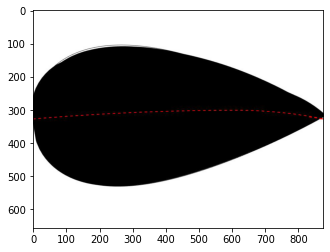

In [6]:
#SELF TEST
#use this cell to preview any of the images
indx = random.randint(0, len(my_df_train))
img = plt.imread(my_df_train.fpath[indx])
plt.imshow(img)
my_df_train.shape

## Data - part 2
Split your training dataset into training and validation and use ImageDataGenerator to feed it to your model in batches. Apply any transformations necessary.

N.B. Documentation on <code>.flow_from_dataframe</code> method can be found here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe

In [7]:
def create_dataset(my_df):
    ###
    datadir = '/content/resource/asnlib/publicdata'
    img_size = (100,100)
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)
                                  # rotation_range = 20,    # data augmentation
                                  # horizontal_flip = True,
                                  # vertical_flip = True,
                                  # zoom_range = 0.15)
    train_generator = datagen.flow_from_dataframe(dataframe=my_df_train,
                                                  target_size=img_size,
                                                  directory=datadir,
                                                  x_col=list(my_df_train.columns)[0],
                                                  y_col=list(my_df_train.columns)[2],
                                                  subset='training',
                                                  batch_size=64,
                                                  class_mode='sparse')
    
    valid_generator = datagen.flow_from_dataframe(dataframe=my_df_train,
                                                  target_size=img_size,
                                                  directory=datadir,
                                                  x_col=list(my_df_train.columns)[0],
                                                  y_col=list(my_df_train.columns)[2],
                                                  subset='validation',
                                                  batch_size=64,
                                                  class_mode='sparse')


    ###
    return train_generator, valid_generator
train_generator, valid_generator = create_dataset(my_df_train)

Found 4780 validated image filenames belonging to 7 classes.
Found 1194 validated image filenames belonging to 7 classes.


In [8]:
assert 'Iterator' in str(type(train_generator)),"Make sure you use ImageDataGenerator"
assert train_generator.split[0] >= 0.2, "At least 20% of your data should be assigned to test dataset"
assert train_generator.class_mode!='binary', "Binary mode cannot be used on data with more than 2 classes"

# MODEL
Define and compile your CNN model here. Your function <code>build_model</code> should take in two arguments: image width (<code>im_width</code>) and height (<code>im_height</code>) and return a **compiled model**. The compiled model should have <code>"accuracy"</code> as one of your metrics.

In [9]:
###
### YOUR CODE HERE
def build_model(im_width, im_height):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (im_width, im_height, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
       
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(7, activation = 'softmax')
    ])

    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                  metrics = ['accuracy'])
    return model
###
im_width  = train_generator.next()[0].shape[1]
im_height = train_generator.next()[0].shape[2]
model = build_model(im_width, im_height)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8464)              0         
                                                                 
 dense (Dense)               (None, 64)                5

In [10]:
assert any('conv2d' in layer for layer in list(layer.name for layer in model.layers)), "Your model should contain at least one convolutional layer" #check if model contains convolutional layers
assert (model.input.shape[1], model.input.shape[2]) == train_generator.target_size, "Your model input does not match training dataset format"#check input size

# TRAINING
Create a function for training of the model that predicts the correct AoA at least 99% of the time. For grading purposes, your training should be done within 29 minutes. However, try to see if you can achieve best accuracy without submission by allowing your model to train for longer.

Hint: if the number of steps per epoch returns <code>Unknown</code> you need to specify <code>steps_per_epoch</code> and <code>validation_steps</code> inside your <code>train_model</code> function.

In [12]:
def train_model(train_generator, valid_generator):
    start_time = time.time()
    ###
    history = model.fit(train_generator, 
                        epochs = 5,
                        validation_data = valid_generator,
                        verbose = 1)
    ###
    end_time = time.time()
    runtime = end_time - start_time
    
    return runtime, history, model
training_time, history, model = train_model(train_generator, valid_generator)
print('Training time: ', round(training_time/60,2), 'mins.')

Epoch 1/5
75/75 [==============================] - 48s 623ms/step - loss: 0.0200 - accuracy: 0.9939 - val_loss: 0.0285 - val_accuracy: 0.9941
Epoch 2/5
75/75 [==============================] - 40s 529ms/step - loss: 0.0131 - accuracy: 0.9964 - val_loss: 0.0300 - val_accuracy: 0.9933
Epoch 3/5
75/75 [==============================] - 40s 531ms/step - loss: 0.0125 - accuracy: 0.9964 - val_loss: 0.0223 - val_accuracy: 0.9941
Epoch 4/5
75/75 [==============================] - 40s 532ms/step - loss: 0.0084 - accuracy: 0.9979 - val_loss: 0.0208 - val_accuracy: 0.9975
Epoch 5/5
75/75 [==============================] - 39s 519ms/step - loss: 0.0037 - accuracy: 0.9998 - val_loss: 0.0188 - val_accuracy: 0.9975
Training time:  3.49 mins.


In [13]:
###
### AUTOGRADER TEST - DO NOT REMOVE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (100,100)
datadir = '/content/resource/asnlib/publicdata'
datagen = ImageDataGenerator(rescale = 1./255)

test_generator = datagen.flow_from_dataframe (dataframe=my_df_test,
                                              target_size=img_size,
                                              directory=datadir,
                                              x_col=list(my_df_test.columns)[0],
                                              y_col=list(my_df_test.columns)[2],
                                              batch_size=20,
                                              class_mode='sparse',
                                              shuffle=False)
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.evaluate(test_generator)
###


Found 664 validated image filenames belonging to 7 classes.
34/34 [==============================] - 5s 135ms/step - loss: 0.0356 - accuracy: 0.9925


[0.0355568565428257, 0.9924699068069458]

In [15]:
model.save('/content/drive/MyDrive/AI4AE')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI4AE/assets
